# Introduction #
In this notebook, I will analyze data and train a model to predict whether mushrooms are poisonous or edible.
From the competition description: "The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset . . . data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original."

## Imports ##

In [1]:
import warnings

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.metrics import matthews_corrcoef #Scoring system of competition
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


#Allow more columns to be displayed
pd.set_option('display.max_columns', 50)

# Mute warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv", index_col="id")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv", index_col="id")

# Exploratory Data Analysis #

In [3]:
print(df_train.shape)
print(df_test.shape)

(3116945, 21)
(2077964, 20)


With such a large dataset, reducing dimensionality and optimizing speed will probably be necessary

In [4]:
df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
df_train.dtypes

class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

Most of the features are categorical. These will need to be encoded.

Here are the unique values in the training and testing datasets:

In [6]:
#Prints unique values in categorical features
def print_unique(df_train, df_test):
    for col in df_test.select_dtypes(["object", "category"]).columns:
        print(f"Train {col}: {df_train[col].unique()}")
        print(f"Test {col}: {df_test[col].unique()}")
print_unique(df_train, df_test)

Train cap-shape: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']
Test cap-shape: ['x' 'o' 'b' 'f' 's' 'p' 'c' 'g' 't' 'i' 'a' 'n' '7.21' 'e' nan 'w' 'd'
 'k' 'u' 'y' '3.34' '8.3' 'r' 'l' '3.32' '19.76' 'is f' '0.93' '5 f' 'z'
 'p f' 'h' '1.25' 'm' '4.55' 'ring-type' '11.43' '6' '5.59' '4.41' '3.73'
 '3.47' '6.75' '51.63' '6.52' '9.49' '2.7' '3.15' '5.05' 'cap-diameter'
 '4.51' '4.86' '0.97' '3.94' '6.47' '3.23' '2.02' '1.53' '8' '6.15'
 '17.89' '0.74' '4.54']
Train cap-surface: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does 

Here is the data description from the UCI mushroom dataset:     
     
1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4. bruises?:                 bruises=t,no=f
5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment:          attached=a,descending=d,free=f,notched=n
7. gill-spacing:             close=c,crowded=w,distant=d
8. gill-size:                broad=b,narrow=n
9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
10. stalk-shape:              enlarging=e,tapering=t
11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
16. veil-type:                partial=p,universal=u
17. veil-color:               brown=n,orange=o,white=w,yellow=y
18. ring-number:              none=n,one=o,two=t
19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
21. population:               abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d
    
Compared to the original UCI dataset, our given data has much more noise. There are many numerical and categorical values that aren't present in the original dataset. Additionally, the three numerical features given were completely absent from UCI's dataset. This means that we probably shouldn't rely on the UCI dataset too much and should just focus on our given training data.

Here are the distribution plots of each categorical feature in the training data:

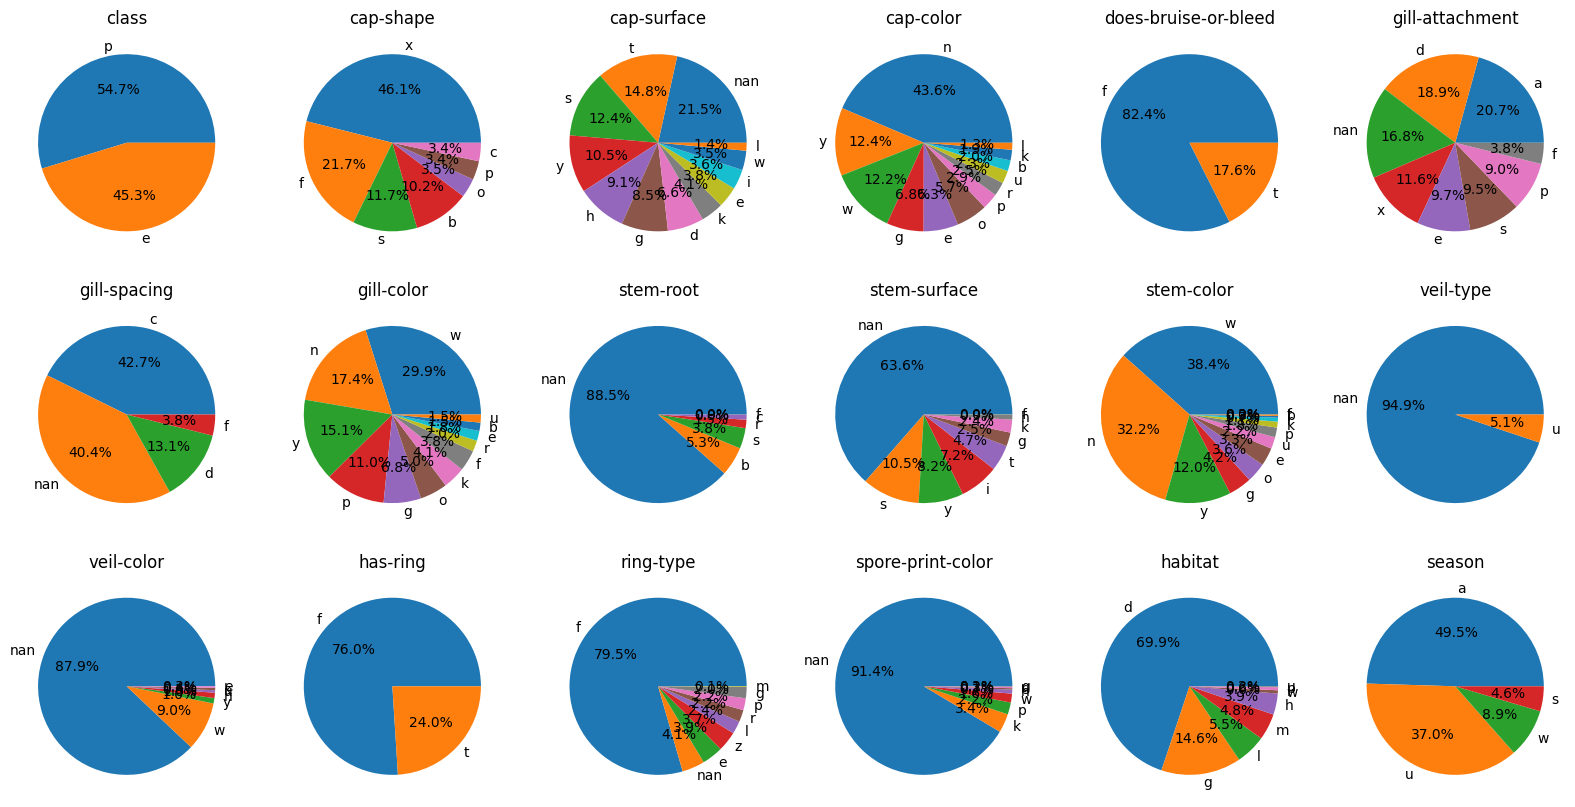

In [7]:
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
axs = axs.flatten()

for i, col in enumerate(df_train.select_dtypes(["object"]).columns):
    #Get counts and filter out if count is less than 100
    counts = df_train[col].value_counts(dropna=False) #Keep NaN
    counts = counts[counts > 100]
    
    axs[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
    axs[i].set_title(col)

Here are the distribution plots of each numerical feature in the training data:

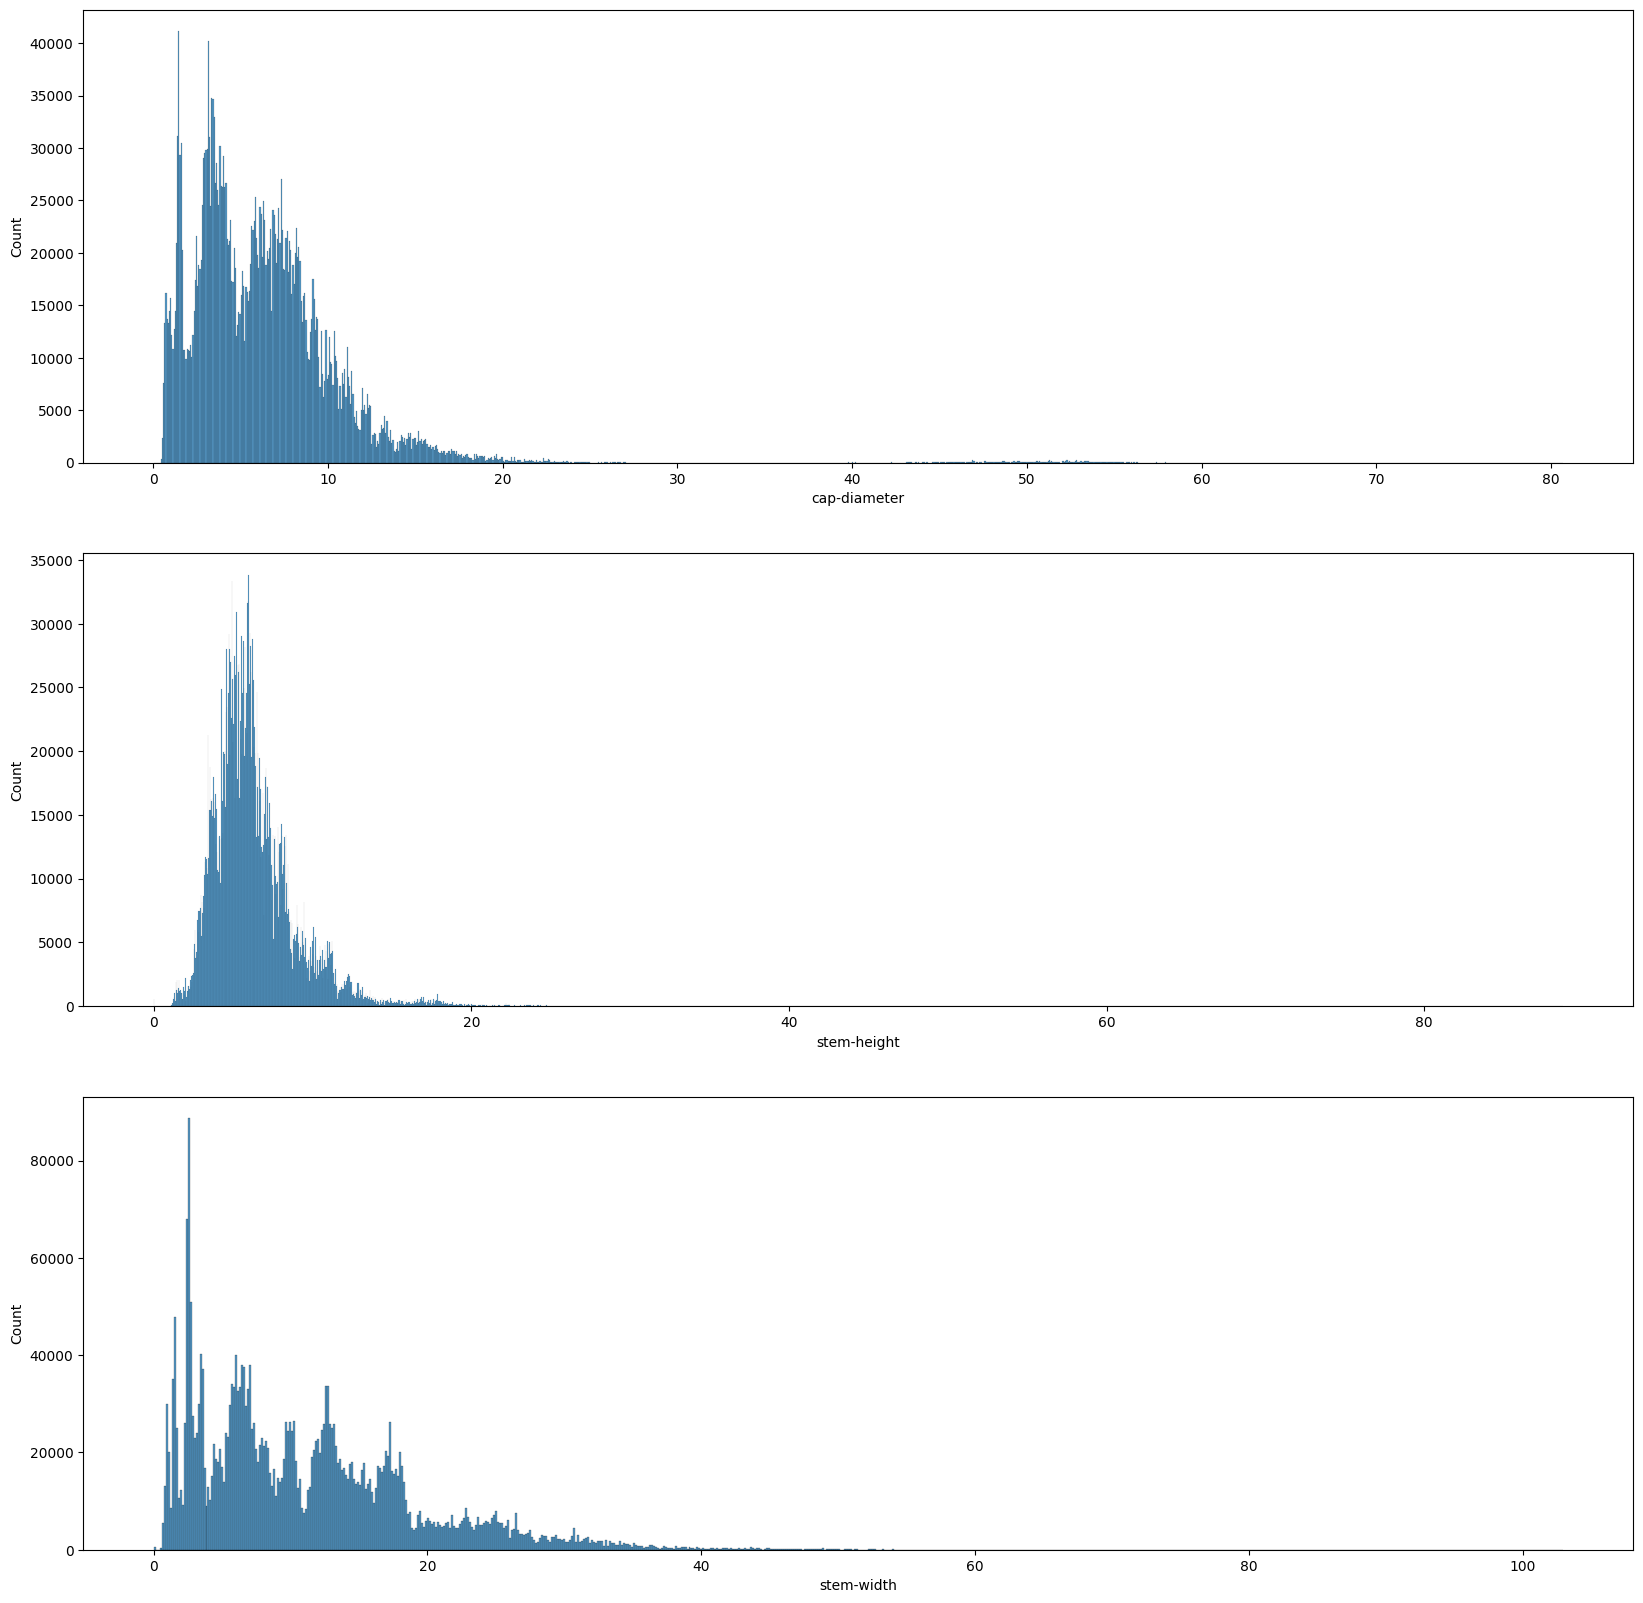

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(20,20))
for i, col in enumerate(df_train.select_dtypes(["float64"])):
    sns.histplot(df_train[col], ax=axs[i])

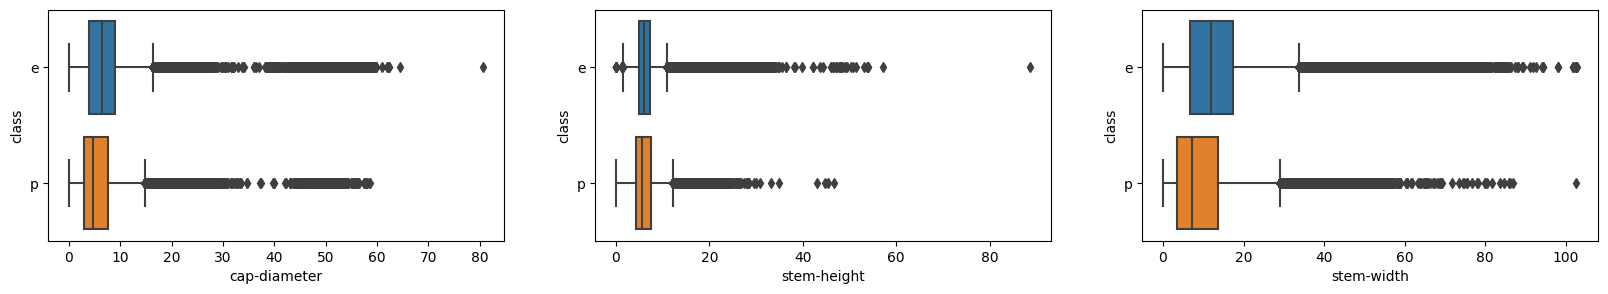

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20,3))
axs = axs.flatten()
for i, col in enumerate(df_train.select_dtypes(["float64"])):
        sns.boxplot(x=df_train[col], y=df_train["class"], ax=axs[i])

In the boxplots above, we see that there are many outliers. It may be beneficial to numerically transform the columns to reduce the impact of outliers on our model's performance.

Let's look at how the numerical features interact with each other now.

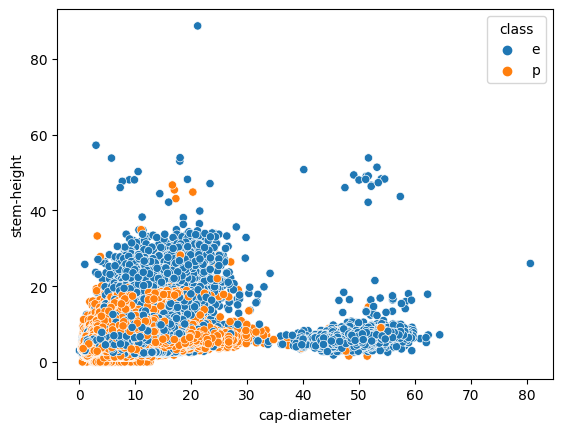

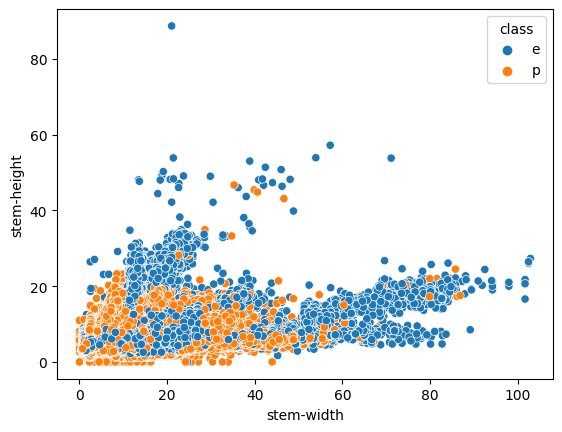

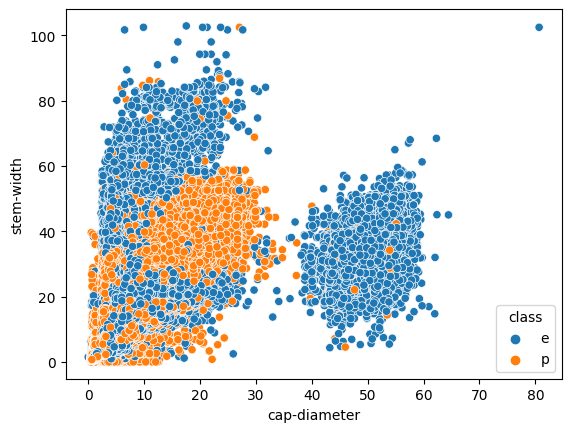

In [10]:
def make_scatterplot(col1, col2):
    fig, ax = plt.subplots()
    sns.scatterplot(data=df_train, x=col1, y=col2, hue="class")
    
make_scatterplot("cap-diameter", "stem-height")
make_scatterplot("stem-width", "stem-height")
make_scatterplot("cap-diameter", "stem-width")

We can see that there are strong groupings where mushrooms are more likely to be of a certain class. This suggests that incorporating some method of clustering may be beneificial for model performance.

Percentage of each column that is NaN:

In [11]:
na_percentage = df_train.isna().sum().sort_values(ascending=False)/df_train.shape[0]*100
na_percentage

veil-type               94.884350
spore-print-color       91.425482
stem-root               88.452732
veil-color              87.936970
stem-surface            63.551362
gill-spacing            40.373988
cap-surface             21.528227
gill-attachment         16.809280
ring-type                4.134818
gill-color               0.001829
habitat                  0.001444
cap-shape                0.001283
stem-color               0.001219
has-ring                 0.000770
cap-color                0.000385
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
class                    0.000000
stem-width               0.000000
stem-height              0.000000
season                   0.000000
dtype: float64

Quite a few features have a majority of NaN values.

# Preprocessing #

This function will return our datasets after they have been cleaned, encoded, and imputed.

In [12]:
def load_dataframes():
    df_train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv", index_col="id")
    df_test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv", index_col="id")
    
    df = pd.concat([df_train, df_test])
    clean(df)
    encode(df)
    impute(df)
    
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    df_test = df_test.drop("class", axis=1)
    
    return df_train, df_test

## Cleaning ##
For each feature, values are not present in the testing data will be converted to NaN in the training data. This will easily reduce noise. Furthermore, only values that are strings of length one will be kept since other values seem to be errors in the data. Lastly, values with fewer than 100 appearances will also be converted to NaN because this amount is extremely small compared to the dataset size. Reducing the number of unique values will help with one hot encoding.

In [13]:
#Generate dictionary of allowed values
allowed_vals = {"class" : ["e", "p", np.nan]}

for col in df_test.select_dtypes("object").columns:
    allowed_vals[col] = df_test[col].unique()
    
    #Filter allowed_vals to only have NaN and strings that are an alpabetical character
    boolean_array = pd.isna(allowed_vals[col]) | (np.array([len(str(val)) == 1 and str(val).isalpha() for val in allowed_vals[col]]))
    allowed_vals[col] = allowed_vals[col][boolean_array]
    
    #Filter allowed_vals to only have values that appear at least 100 times.
    value_counts = df_test[col].value_counts()
    allowed_vals[col] = value_counts[value_counts >= 100].index
    
    #Replace values not in allowed_vals with NaN
    df_train.loc[~df_train[col].isin(allowed_vals[col]), col] = np.NaN
    df_test.loc[~df_test[col].isin(allowed_vals[col]), col] = np.NaN

print_unique(df_train, df_test)

Train cap-shape: ['f' 'x' 'p' 'b' 'o' 'c' 's' nan]
Test cap-shape: ['x' 'o' 'b' 'f' 's' 'p' 'c' nan]
Train cap-surface: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k']
Test cap-surface: [nan 't' 'g' 'h' 'd' 'e' 'y' 'k' 's' 'i' 'l' 'w']
Train cap-color: ['u' 'o' 'b' 'g' 'w' 'n' 'e' 'y' 'r' 'p' 'k' 'l' nan]
Test cap-color: ['n' 'o' 'y' 'k' 'b' 'w' 'e' 'g' 'p' 'u' 'l' 'r' nan]
Train does-bruise-or-bleed: ['f' 't' nan]
Test does-bruise-or-bleed: ['t' 'f' nan]
Train gill-attachment: ['a' 'x' 's' 'd' 'e' nan 'f' 'p']
Test gill-attachment: [nan 's' 'p' 'x' 'f' 'a' 'd' 'e']
Train gill-spacing: ['c' nan 'd' 'f']
Test gill-spacing: [nan 'c' 'f' 'd']
Train gill-color: ['w' 'n' 'g' 'k' 'y' 'f' 'p' 'o' 'b' 'u' 'e' 'r' nan]
Test gill-color: ['w' 'y' 'n' 'e' 'f' 'b' 'g' 'p' 'o' 'u' 'k' 'r' nan]
Train stem-root: [nan 'b' 'c' 'r' 's' 'f']
Test stem-root: ['b' nan 's' 'r' 'c' 'f']
Train stem-surface: [nan 'y' 's' 't' 'g' 'h' 'k' 'i' 'f']
Test stem-surface: [nan 's' 'g' 'y' 't' 'i' 'k' 'h' 'f']
Train s

In [14]:
#Replaces values that aren't in allowed_vals with NaN
def clean(df):
    for col in df.select_dtypes("object").columns:
        df.loc[~df[col].isin(allowed_vals[col]), col] = np.NaN     
    return df

## Encoding ##
Categorical columns will be encoded as `category` type to allow one hot encoding later.

In [15]:
def encode(df):
    for col in df.select_dtypes("object").columns:
        df[col] = df[col].astype("category")
        #Add none value for imputation later
        df[col] = df[col].cat.add_categories("None")

## Imputation ##
Many of the categorical features have a large percentage of rows missing. 
I chose not to drop these features due to their high predictive power, mentioned in this helpful notebook [https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523474](http://) by Matt.

To impute them, we'll replace NaN values with `"None"`. For categorical features with only a few rows missing, the NaN values will just be imputed with the most common value. The only numerical feature with missing values is `cap-diameter`. Since only a small percentage of the data is missing, the NaN values will just be imputed with the median value.


In [16]:
def impute(df):
    #Impute high NaN features with "None"
    high_na = na_percentage[na_percentage > 10].index
    df[high_na] = df[high_na].fillna("None")
    
    #Impute other features with most common value 
    for col in df.select_dtypes("category").columns:
        if col not in high_na and col != "class":
            common_val = df[col].mode()[0]
            df[col] = df[col].fillna(common_val)
            
    #Impute numerical feature with median
    median = df["cap-diameter"].median()
    df["cap-diameter"] = df["cap-diameter"].fillna(median)
    
    return df

Let's get our preprocessed dataframes now:

In [17]:
df_train, df_test = load_dataframes()

In [18]:
df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,None,None,w,None,None,f,f,None,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,None,y,o,None,None,t,z,None,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,None,s,n,None,None,f,f,None,l,w
3,e,3.88,f,y,g,f,s,None,g,4.16,6.53,None,None,w,None,None,f,f,None,d,u
4,e,5.85,x,l,w,f,d,None,w,3.37,8.36,None,None,w,None,None,f,f,None,g,a


In [19]:
#No NaN values
df_train.isna().any().any()

False

#